# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

**Answer:** I think that PCA will find vectors which represent some sort of gradient - certain products which are generally purchased together, the first eigenface will probably be some average of certain products purchasing.  ICA will find vectors which represent customers of certain types, perhaps people who buy detergents also buy milk, or something like that. Some sort of correlation between different types of customers, those who own a bar, or own a butcher shop etc.

### PCA

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


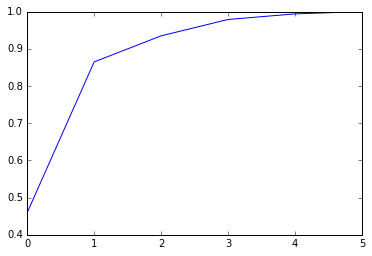

In [2]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
from sklearn import preprocessing

pca = PCA(n_components = 6)
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

plt.plot(np.cumsum(pca.explained_variance_ratio_))

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: The above plot shows the variance accounted for as we add PCA vectors in order of magnitude.  We see that by the first second vector (indexed at 1) almost 90% of the total variance is accounted for. For this reason I would use the first two dimensions for my analysis, as they contain the majority of the variance by far.  Also, limiting to two vectors allows me to do cool visualizations, which is an added bonus

(-1, 1.5)

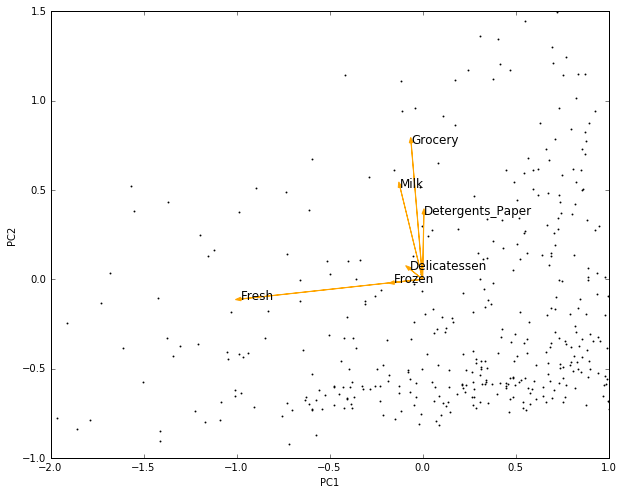

In [3]:
def biplot(df):
    # Fit on 2 components
    pca = PCA(n_components=2, whiten=True).fit(df)
    
    # Plot transformed/projected data
    ax = pd.DataFrame(pca.transform(df),
        columns=['PC1', 'PC2']
    ).plot(kind='scatter', x='PC1', y='PC2', figsize=(10, 8), s=0.8)

    # Plot arrows and labels
    for i, (pc1, pc2) in enumerate(zip(pca.components_[0], pca.components_[1])):
        ax.arrow(0, 0, pc1, pc2, width=0.001, fc='orange', ec='orange')
        ax.annotate(df.columns[i], (pc1, pc2), size=12)

    return ax

ax = biplot(data)
ax.set_xlim([-2, 1])
ax.set_ylim([-1, 1.5])

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: Using a biplot, we can see what the first two dimensions appear to represent.  In this biplot PC1 has a large magnitude for Fresh and much smaller for Frozen and Delicatessen. PC2 is has a large magnitude for Milk, Grocery, and Detergents_Paper. If consider the PCA vectors as composite features, then we can imagine PC1 as a feature which generally represents the Fresh, with a small amount of Frozen and Deli.  Similarily PC2 represents Milk, Grocery and Detergents_paper, in that order. PCA provides us with a feature that contains within it information from other features, the magnitude of each coeffecient component in the PCA vector tells us how strong it is affecting that particular sub-feature. 

For a wholesale distributor this type of knowledge is quite useful because we can represent three items in one feature.  Later in this report we cluster the stores based on these features, which allows us to define stores as purchasing mainly PC1 or PC2 goods, with this knowledge the distributor can target advertisements, deals, product changes, and many other options, to the correct type of customer.  

One idea the distributor could use: reduce the cost of a very essential item (grocery), this would help insure that customers would buy from us (we're cheap). At the same time, raise the cost of a less bought item (detergent_paper), but one that is bought in tandem with the cheaper item. The customer will probably buy both of them from us anyways, because they buy all their products from one distributor.  This is similar to cheap printers with very expensive ink.  By lowering a key item, we hook the customer but also get their business for the other products which we know they will be (since these items are bought in groups). 

We can infer these relationships numerically as well (without the biplot), simply examining the magnitude on the signs, for PC1 (the first row vector), we see -9 on Fresh, with the rest of the features having either a small negative, or very close to 0 magnitude.  This suggests that the main feature affected by PC1 is Fresh.  Which means there are stores which only buy fresh produce (or mostly fresh produce).  This feature could be very useful, we know that we can probably shift delivery times for fresh produce without affecting other stores, it's a single type of customer.



### ICA

[[  3.97596282e-06  -8.58804422e-07  -6.27469785e-07  -6.77279603e-07
    2.06698062e-06  -1.04227439e-06]
 [  2.10733777e-07  -1.87975348e-06   6.42278616e-06   4.11383263e-07
   -8.04988405e-07  -1.45823313e-06]
 [  1.53023680e-07   9.84836364e-06  -5.80431241e-06  -3.65167925e-07
    3.29363940e-06  -6.06103841e-06]
 [  3.86495528e-07   2.19445562e-07   6.00061772e-07   5.22125539e-07
   -5.08737108e-07  -1.80922704e-05]
 [ -2.99294418e-07   2.29931519e-06   1.20639216e-05  -1.46244818e-06
   -2.82088722e-05  -5.72776175e-06]
 [  8.65179584e-07   1.40470208e-07  -7.73705063e-07  -1.11461715e-05
    5.54595060e-07   5.95211374e-06]]


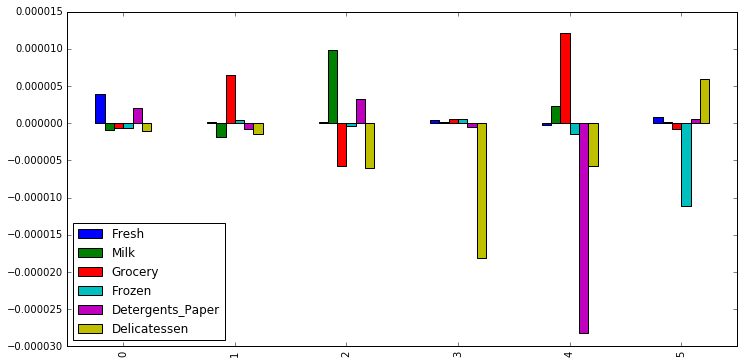

In [92]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA

centered_data = data - data.mean()
ica = FastICA(n_components=6 , random_state = 1)
ica.fit(centered_data)



# Print the independent components
print ica.components_

pd.DataFrame(ica.components_, columns = data.columns).plot(kind = 'bar', figsize = (12,6))

**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: Each component of the ICA decomposition highlights an independent row vector of the unmixing matrix.  Essentialy these vectors tell us about strong independant signals. Viewing the above bar chart we can see the relationship between the features in each ICA vector.  It's important to note that the sign (positive / negative) does not really tell us what the store is buying / not buying.  Because ICA can flip signs, we only know the relative relationship between positive and negative features, that they are polar opposites, we don't know which vector represents "buying" vs "not buying".

So in all the following analysis, I first assume the positive is "buying" but if that makes no sense, I flip the analysis and assume the negative is "buying".

We're looking for a place that generally buys Detergents_Paper, Delicatessen, some frozen and fresh, without much grocery and milk.  I'd guess a corner / convenience store.  The opposite (buys grocery's and milk) seems less likely.

(0) This is a store that buys fresh and paper, perhaps it's an outdoor shop that sells fresh fruit and paper products.  However this type of store doesn't have refrigeration, so there are no perishable items which require storage? meh, probably not.  Let's consider the opposite.  A store that buys Frozen goods, groceries, milk and deli meats.  Probably your typical grocery store with a deli counter.  Just doesn't have much detergents/paper or fresh goods.

(1)  This is a classic grocery store, Lots of groceries, a bit of frozen and fresh. Some sort of strange inverse relationship with milk.  Maybe it's a vegan grocery store!

(2) This is most likely a grocery / deli store.  The strong inverse relationship to milk is puzzling, again perhaps it's a vegan joint!

(3) This store is probably a deli that makes sandwiches and sells them in paper product for consumption. Note the very small detergents_paper magnitude

(4) This is a strange one, we have a very large negative magnitude for Detergents_paper, however a store that specializes in paper / detergents and a small deli?  Perhaps a corner store, depending on what is really sold as detergents_paper.  The other option is to consider a grocery store, which has some dairy, but almost NO detergents paper.  It's a toss up in my mind.

(5) This could be some kind of frozen goods store, since that's not very likely I'd guess it's opposite.  A Deli, that has some fresh products, paper products and no frozen section at all.

These components could be used to understand what types of customers we have in general.  Understanding which items are frequently bought together versus not bought together would certainly help planning deliveries.

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: K-means clustering differs from Gaussian Mixture Models mainly in that GMM implements a probabilistic model. GMM will allow for softer boundaries, allowing a datapoint to be assigned to multiple centroids, utilizing probabilities. K-means also relies on inertia, which assumes that the clusters will be isotropic and convex.  However GMM does not scale well (at all!), but since our data is quite small here, we'll be fine to use it.
(http://scikit-learn.org/stable/modules/clustering.html). 

I will use GMM in order to take advantage of the probabilitistic nature, we'll be able to perceive the softer boundaries.  We will decide on the number of clusters by trying different amounts and visualizing, we should be able to perceive what works best.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [5]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [137]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
pca = PCA(n_components = 2)
reduced_data = pca.fit_transform(data)
print reduced_data[:10]  # print upto 10 elements


[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [138]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
g = GMM(n_components=4)
clusters = g.fit(reduced_data)
print clusters

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=4, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


In [139]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [140]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids = clusters.means_
print centroids

[[  7174.54719282   5469.02876453]
 [  2339.15204219  -6708.93065712]
 [ -9486.9742574   34645.20428228]
 [-15372.37194307  -3334.43379857]]


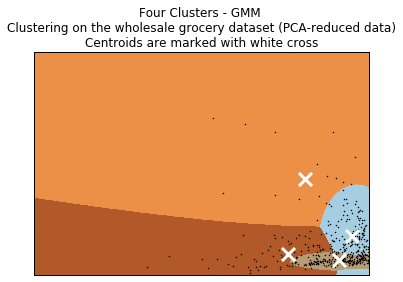

In [141]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Four Clusters - GMM \n'
          'Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

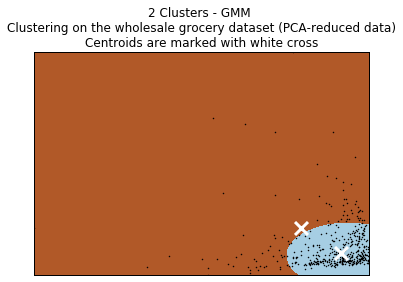

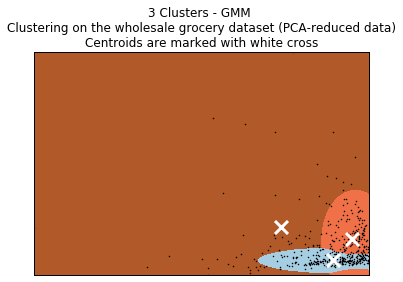

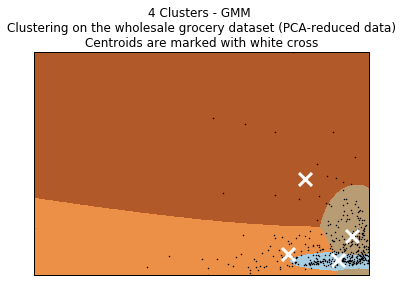

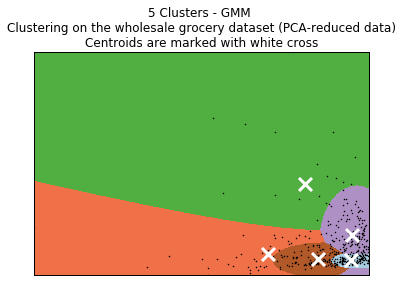

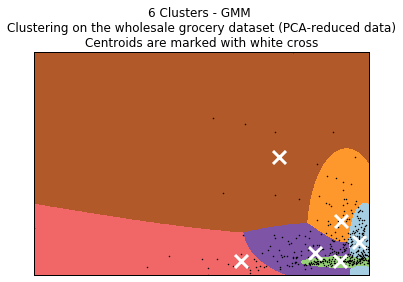

In [142]:
def plot_clusters(num_clusters,label_on = None, pass_centroids = None):
    g = GMM(n_components=num_clusters)
    clusters = g.fit(reduced_data)

    # Plot the decision boundary by building a mesh grid to populate a graph.
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    hx = (x_max-x_min)/1000.
    hy = (y_max-y_min)/1000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

    centroids = clusters.means_

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    
    plt.scatter(centroids[:,0], centroids[:,1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    
    labels = ['{0}'.format(i) for i in range(num_clusters)]
    if label_on == True:
        for label, x, y in zip(labels, centroids[:,0], centroids[:,1]):
                    plt.annotate(
                        label, 
                        xy = (x, y), xytext = (-20, 20),
                        textcoords = 'offset points', ha = 'right', va = 'bottom',
                        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
    plt.title('%s Clusters - GMM \n'
              'Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross' % num_clusters)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
    if pass_centroids == True:
        return centroids
    
plot_clusters(2)
plot_clusters(3)
plot_clusters(4)
plot_clusters(5)
plot_clusters(6)

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: In the above visualizations we can observe five different cluster graphs.  In fact, GMM does quite well and in all versions it seems to find very reasonable clusters.  However I would choose 5 clusters (shown below) as this seems to best represent the findings.  

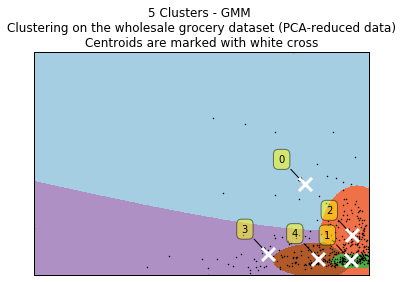

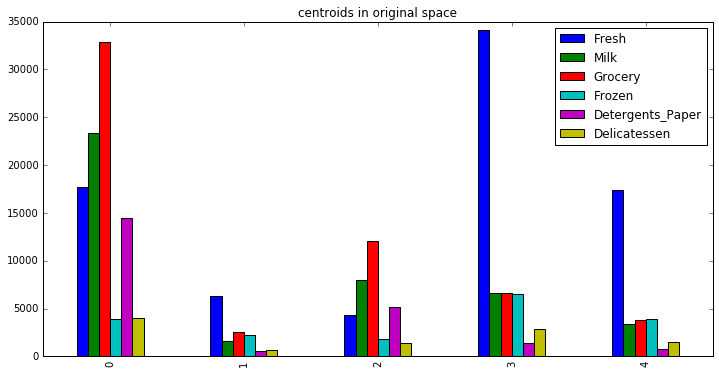

In [143]:
centroids = plot_clusters(5, label_on = True, pass_centroids= True)

centroids_original_shape = pca.inverse_transform(centroids)
pd.DataFrame(centroids_original_shape, columns = data.columns).plot(kind = 'bar',
                                                figsize = (12,6) ,title = "centroids in original space")

Here we have two figures, the first is the a five cluster visualization, the second is a bar chart which shows the same centroids in the original data-space (after using PCA_inverse_transform). Note that these centroids are not representing real stores but are data arch-types of the clusters, they represent the average store for each cluster. 
___

Centroid **1** in the lower right quadrant represents a store which is evenly affected by both PC1 and PC2, thus the relationship between all the features are quite even and this is accurately reflected in the original space.  Looking at the bar chart, we see that centroid **1** has low values for all features and slightly more _fresh_, this makes sense because PC1 contains a very high magnitude for _fresh_ (see biplot above).  Given the number of points in this cluster, this is the **most common** store and this make sense, it's a simple grocery store that has more fresh produce than anything else.  Note that the volume of purchase on this store is not that great, so we can probably conclude that they are smaller stores, perhaps corner stores which are a mix of all products (with an emphasis on fresh).
___
Centroid **4** is also in the lower right, sitting to the left of **1**, centroid **4** represents stores which are affected by PC1 more than PC2.  This is reflected in the original space, we see that _fresh_ purchases are much stronger, which again makes sense as _fresh_ dominates PC1.

___
Centroid **2** is in the lower right above centroid**1**, it represents stores which are affected more by PC2 than PC1.  In the original space we see a store that has relatively even purchases but highlights, _grocery, milk, and detergents-paper_, this is very intuitive as PC2 highlights those features, and note that _grocery_ has the strongest magnitude in PC1 and we see this displayed in the original space for centroid **2**

___
Both centroids **4** and **2** represent the second most common types of stores, and this is also intuitive, they are stores which either specialize in either fresh produce, or milk, groceries and paper supplies, their volume is not that great, so they are probably either smaller corner fresh stores or convenience stores.

___
Cenroid **3** represents stores which are dominated by PC1, and there are less of these stores.  This is well represented in the original space, we see a store with massive purchase of _fresh_, this is perhaps a farmers market.  There are less of these stores and that is reflected in the cluster map.

___
Centroid **0** represents stores which are both affected by PC1 and PC2, but more dominated by PC2.  These are stores with very large purchases, which emphasize _grocery_, _milk_, and _detergents-paper_, although _fresh_ certainly plays a role.  These are probably bigger chain grocery stores, which have a mix of everything. Again, they are fewer in number.


This analysis is quite intuitive and the clustering overall shows good results.  Sampling the cluster centroids produces stores which are very much in line with the analysis of the PCA vectors.

### Conclusions

**8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: PCA combined with GMM are the most useful techniques because of them we are able to reduce the dimesionality of the data and then use GMM to create very useful clusters. The ability to label a store allows us to target specific customers.  In the next two questions we will explore how to take advantage of this.  If you force me to pick one single techinque, I'd choose PCA, because I don't think GMM would be nearly as effective without PCA behind it.   PCA alone allows us to project any single store into the PCA space (which is what we see in the cluster visualization, all the dots are individual stores projected into the PCA space). In the PCA space we can examine a single store (dot) and do the same analysis that was done for the centroid stores, i.e: which PCA vectors are affecting it, what does that mean etc.

**9)** How would you use that technique to help the company design new experiments?

Answer:  PCA allows to us classify a store (based on it's purchase history) into one of the five clusters.  We could conduct A/B tests on stores of individual clusters to see what types of purchasing that _type_ preferred.  For example a store in cluster **3** should have a high standard or demand for _fresh_, so one A/B test could be to split the cluster in **3** into two groups, A and B.  Then lower the price of fresh produce for A (but not B) and seeing if there would be an increase in purchase in A. If there was an increase in purchase for only A, then we can attribute it the price, otherwise it wouldn't be relevant (could be just a busy season)  Another would be to conduct a similar A/B split and offer more delivery options to A (but not B) and see if this increased loyalty from a store.

**10)** How would you use that data to help you predict future customer needs?

Answer: I'd try to run linear regressions for the clusters we've found.  Take a cluster, run regression and find likely purchase orders from that store.  Another option would be to setup a classification system, extract features from the current stores and use their current cluster as a label.  In this way we could classify new stores which we don't have purchase history on, and be able to predict what kinds of products they will want.
